In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import torch
import torch.nn as nn
from torch.autograd import grad
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import joblib

# deterministic seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)


In [2]:
import numpy as np
import torch

# Path to your file (same folder as notebook)
data_path = './heat_sensor_data_sparse.npz'
alpha = 0.04

# Load dataset
data = np.load(data_path)
print("Loaded file:", data_path)
print("Keys in file:", list(data.keys()))

# Expect keys: 'x', 't', 'sensor_readings'
x_obs = np.array(data['x']).reshape(-1, 1)
t_obs = np.array(data['t']).reshape(-1, 1)
u_obs = np.array(data['sensor_readings']).reshape(-1, 1)

print("Loaded sensor data shapes:")
print("x:", x_obs.shape, "t:", t_obs.shape, "u:", u_obs.shape)

# Preview first few samples
print("\nSample readings (first 5):")
for i in range(min(5, len(x_obs))):
    print(f"x={x_obs[i,0]:.3f}, t={t_obs[i,0]:.3f}, u={u_obs[i,0]:.3f}")

# Convert to torch tensors for training
x_obs_t = torch.tensor(x_obs, dtype=torch.float32)
t_obs_t = torch.tensor(t_obs, dtype=torch.float32)
u_obs_t = torch.tensor(u_obs, dtype=torch.float32)


Loaded file: ./heat_sensor_data_sparse.npz
Keys in file: ['x', 't', 'sensor_readings']
Loaded sensor data shapes:
x: (60, 1) t: (60, 1) u: (60, 1)

Sample readings (first 5):
x=0.101, t=0.000, u=0.315
x=0.302, t=0.000, u=0.808
x=0.698, t=0.000, u=0.857
x=0.101, t=0.050, u=0.298
x=0.302, t=0.050, u=0.851


In [3]:
class FullyConnectedNN(nn.Module):
    def __init__(self, in_dim=2, hidden=64, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x, t):
        # x,t are (N,1)
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

def pde_residual(model, x, t, alpha):
    # x,t must be torch tensors with requires_grad True for autograd
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)
    u = model(x, t)
    u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    residual = u_t - alpha * u_xx
    return residual

In [4]:
device = torch.device('cpu')   # change to 'cuda' if GPU available
model = FullyConnectedNN().to(device)

# hyperparams
Nf = 1000   # collocation points for PDE residual
Nb = 50    # boundary points
Ni = 50    # initial points
epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

# sampling functions
def sample_interior(n):
    x = torch.rand((n,1))  # in [0,1]
    t = torch.rand((n,1))
    return x, t

def sample_boundary(n):
    t = torch.rand((n,1))
    x0 = torch.zeros((n,1))
    x1 = torch.ones((n,1))
    return x0, x1, t

def sample_initial(n):
    x = torch.rand((n,1))
    t0 = torch.zeros((n,1))
    return x, t0

# prepare sensor data for Ldata
x_data = x_obs_t.to(device)
t_data = t_obs_t.to(device)
u_data = u_obs_t.to(device)

In [5]:
history = {'loss_total': [], 'loss_data': [], 'loss_pde': [], 'loss_bc': [], 'loss_ic': []}
print("Starting physics-informed training for {} epochs".format(epochs))
for ep in trange(epochs, desc='Training PINN'):
    model.train()
    optimizer.zero_grad()
    # data loss
    u_pred_data = model(x_data, t_data)
    Ldata = mse_loss(u_pred_data, u_data)
    # PDE residual loss
    xf, tf = sample_interior(Nf)
    xf = xf.to(device); tf = tf.to(device)
    res = pde_residual(model, xf, tf, alpha)
    Lpde = torch.mean(res**2)
    # boundary loss
    x0, x1, tb = sample_boundary(Nb)
    x0 = x0.to(device); x1 = x1.to(device); tb = tb.to(device)
    u_b0 = model(x0, tb)
    u_b1 = model(x1, tb)
    Lbc = torch.mean(u_b0**2) + torch.mean(u_b1**2)
    # initial condition loss
    xi, ti = sample_initial(Ni)
    xi = xi.to(device); ti = ti.to(device)
    u_ic = model(xi, ti)
    u_ic_target = torch.sin(math.pi * xi)
    Lic = mse_loss(u_ic, u_ic_target)
    # total loss
    L = Ldata + Lpde + Lbc + Lic
    L.backward()
    optimizer.step()
    # logging
    history['loss_total'].append(L.item())
    history['loss_data'].append(Ldata.item())
    history['loss_pde'].append(Lpde.item())
    history['loss_bc'].append(Lbc.item())
    history['loss_ic'].append(Lic.item())

print('Training finished. Final losses: total {:.3e}, data {:.3e}, pde {:.3e}'.format(
    history['loss_total'][-1], history['loss_data'][-1], history['loss_pde'][-1]))

Starting physics-informed training for 20 epochs


Training PINN: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 65.38it/s]

Training finished. Final losses: total 4.738e-01, data 1.041e-01, pde 3.298e-02


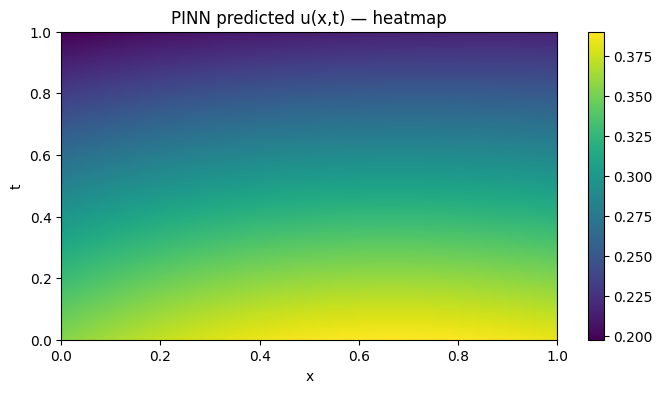

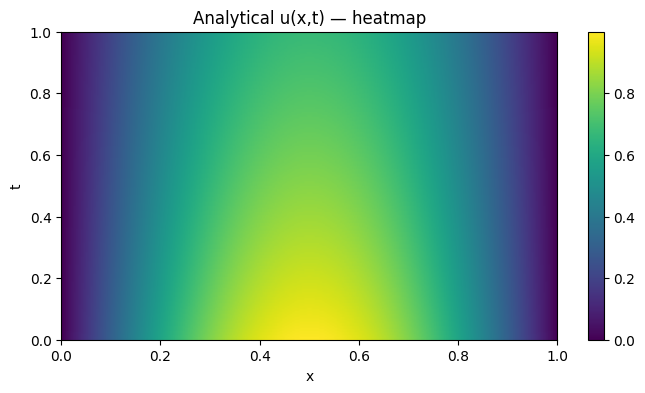

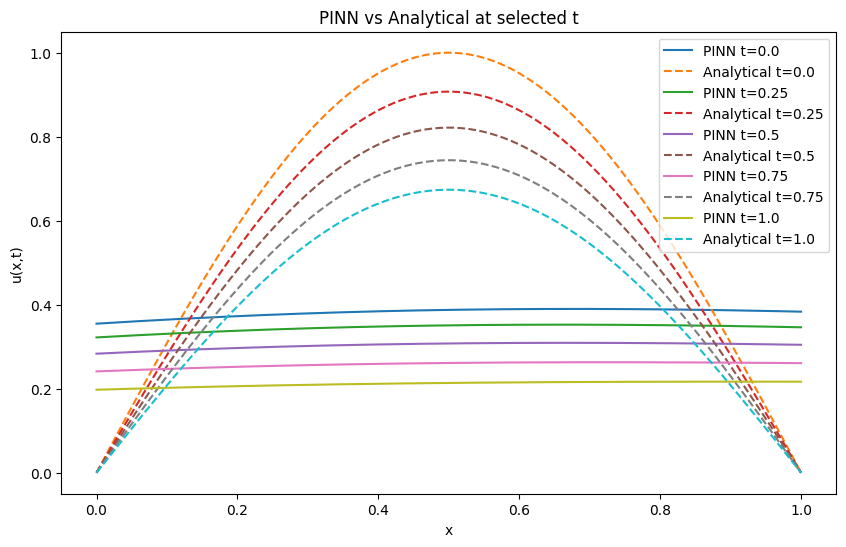

In [6]:
model.eval()
nx, nt = 200, 200
x_vals = np.linspace(0,1,nx)
t_vals = np.linspace(0,1,nt)
X, T = np.meshgrid(x_vals, t_vals)
xt_flat = X.ravel().reshape(-1,1)
tt_flat = T.ravel().reshape(-1,1)

with torch.no_grad():
    x_test = torch.tensor(xt_flat, dtype=torch.float32)
    t_test = torch.tensor(tt_flat, dtype=torch.float32)
    u_pred_flat = model(x_test, t_test).cpu().numpy().reshape(nt, nx)

# analytical
u_true = np.exp(-alpha * (np.pi**2) * T) * np.sin(np.pi * X)

# Plot: predicted field (heatmap)
plt.figure(figsize=(8,4))
plt.imshow(u_pred_flat, origin='lower', extent=[0,1,0,1], aspect='auto')
plt.title('PINN predicted u(x,t) — heatmap')
plt.xlabel('x'); plt.ylabel('t')
plt.colorbar(); plt.show()

# Plot: analytical field
plt.figure(figsize=(8,4))
plt.imshow(u_true, origin='lower', extent=[0,1,0,1], aspect='auto')
plt.title('Analytical u(x,t) — heatmap')
plt.xlabel('x'); plt.ylabel('t')
plt.colorbar(); plt.show()

# Compare at selected time instants
time_instants = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(10,6))
for ti in time_instants:
    idx = int(ti*(nt-1))
    plt.plot(x_vals, u_pred_flat[idx,:], label=f'PINN t={ti}')
    plt.plot(x_vals, u_true[idx,:], linestyle='--', label=f'Analytical t={ti}')
plt.legend(); plt.xlabel('x'); plt.ylabel('u(x,t)'); plt.title('PINN vs Analytical at selected t'); plt.show()

Training data-only model for 2000 epochs


Training data-only: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 327.74it/s]


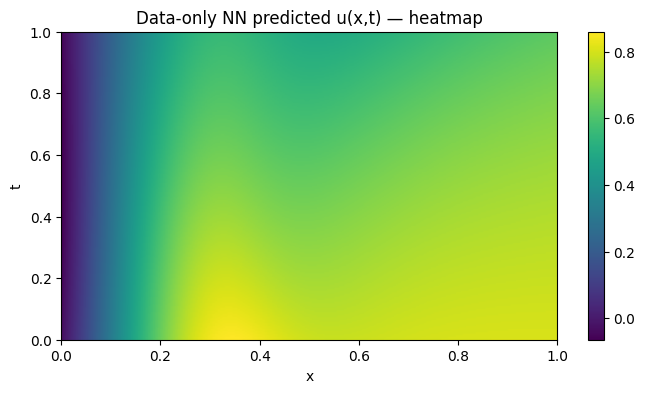

In [7]:
model_data_only = FullyConnectedNN().to(device)
optimizer2 = torch.optim.Adam(model_data_only.parameters(), lr=1e-3)
epochs2 = 2000  # fewer epochs

print("Training data-only model for {} epochs".format(epochs2))
for ep in trange(epochs2, desc='Training data-only'):
    optimizer2.zero_grad()
    u_pred = model_data_only(x_data, t_data)
    Ld = mse_loss(u_pred, u_data)
    Ld.backward()
    optimizer2.step()

# Evaluate on the dense grid
model_data_only.eval()
with torch.no_grad():
    x_test = torch.tensor(xt_flat, dtype=torch.float32)
    t_test = torch.tensor(tt_flat, dtype=torch.float32)
    u_pred_dataonly = model_data_only(x_test, t_test).cpu().numpy().reshape(nt, nx)

plt.figure(figsize=(8,4))
plt.imshow(u_pred_dataonly, origin='lower', extent=[0,1,0,1], aspect='auto')
plt.title('Data-only NN predicted u(x,t) — heatmap')
plt.xlabel('x'); plt.ylabel('t')
plt.colorbar(); plt.show()

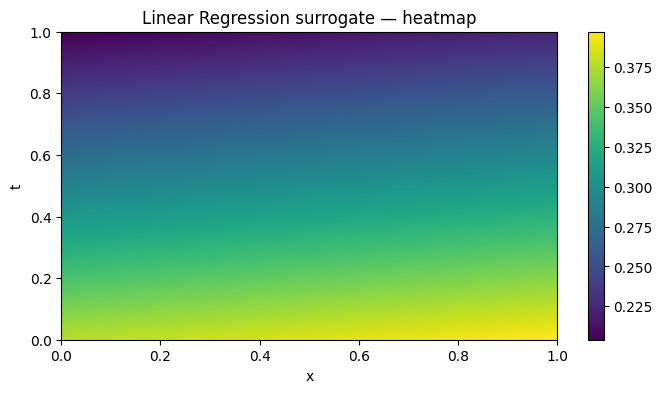

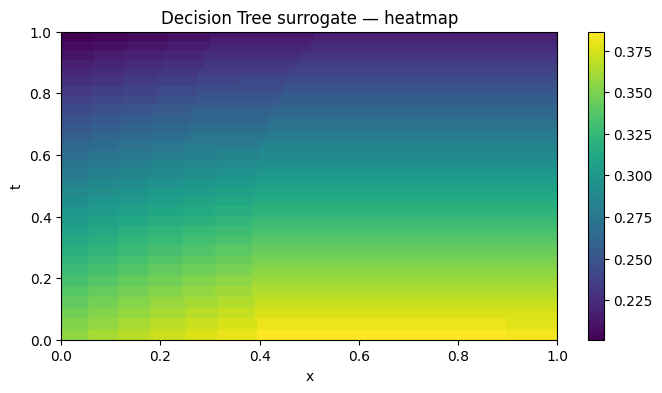

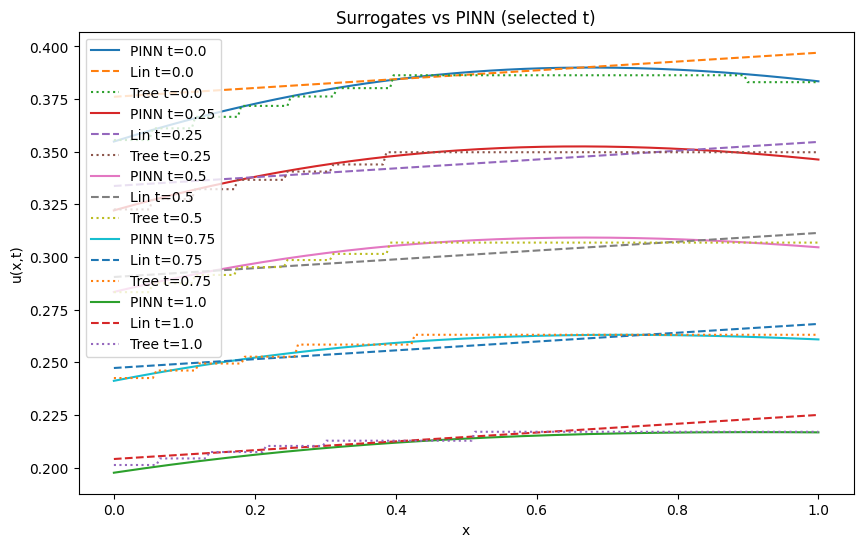

In [8]:
X_sur = np.column_stack([xt_flat, tt_flat])  # (nx*nt, 2)
y_sur = u_pred_flat.ravel()

lin = LinearRegression()
lin.fit(X_sur, y_sur)
y_lin = lin.predict(X_sur).reshape(nt, nx)

tree = DecisionTreeRegressor(max_depth=8)
tree.fit(X_sur, y_sur)
y_tree = tree.predict(X_sur).reshape(nt, nx)

plt.figure(figsize=(8,4))
plt.imshow(y_lin, origin='lower', extent=[0,1,0,1], aspect='auto')
plt.title('Linear Regression surrogate — heatmap')
plt.xlabel('x'); plt.ylabel('t')
plt.colorbar(); plt.show()

plt.figure(figsize=(8,4))
plt.imshow(y_tree, origin='lower', extent=[0,1,0,1], aspect='auto')
plt.title('Decision Tree surrogate — heatmap')
plt.xlabel('x'); plt.ylabel('t')
plt.colorbar(); plt.show()

# Compare slices at selected times (PINN vs Linear vs Tree vs Analytical)
plt.figure(figsize=(10,6))
for ti in [0.0, 0.25, 0.5, 0.75, 1.0]:
    idx = int(ti*(nt-1))
    plt.plot(x_vals, u_pred_flat[idx,:], label=f'PINN t={ti}')
    plt.plot(x_vals, y_lin[idx,:], linestyle='--', label=f'Lin t={ti}')
    plt.plot(x_vals, y_tree[idx,:], linestyle=':', label=f'Tree t={ti}')
plt.legend(); plt.xlabel('x'); plt.ylabel('u(x,t)'); plt.title('Surrogates vs PINN (selected t)'); plt.show()


In [9]:
os.makedirs('./pinn_models', exist_ok=True)
torch.save(model.state_dict(), './pinn_models/pinn_model.pt')
torch.save(model_data_only.state_dict(), './pinn_models/pinn_dataonly.pt')
joblib.dump(lin, './pinn_models/lin_reg.joblib')
joblib.dump(tree, './pinn_models/tree_reg.joblib')
print('Saved models to ./pinn_models')


Saved models to ./pinn_models
